In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=4)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43557 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/43557/status,
Dashboard: /proxy/43557/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.165:40063,Workers: 0
Dashboard: /proxy/43557/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.165:40063' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [9]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [10]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def makeROMSGridObject(ds,rename=True):
    if rename==True:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds, grid

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics={
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [11]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [12]:
def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


In [13]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [14]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy1 = slice('2012-03-06','2012-03-12')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy1 = (str(time_range_to_load_eddy1.start)+' - '+str(time_range_to_load_eddy1.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [15]:
# Load zeta data
# VarToKeep = ['z_rho0','temp','dA','dx','dy','dz']
VarToKeep = ['u_eastward','v_northward','dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)


#load grid file
grid = makeROMSGridObject(truth)

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)

truth["z_rho0"] = truth.z_rho0.fillna(0)
# truth["z_w0"] = truth.z_w.mean(dim='ocean_time')
# truth = truth.drop(['z_w','dz','dx','dy','dA'])

# truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
# truth["dz_w0"]=truth_bu.dz_w.mean(dim='ocean_time')
# truth["dx"] = truth_bu.dx
# truth["z_rho0"] = truth.z_rho0.fillna(0)
# truth["z_w0"]=truth_bu.z_w.mean(dim='ocean_time').fillna(0)
# # truth["s_w"] = truth_bu.s_w
# # truth["s_w3"],dump = xr.broadcast(truth.s_w,truth.lon_rho)

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)


OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

# OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
# OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
# OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
# OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

# OSSE_SSHSST["z_w0"]=OSSE_SSHSST_bu.z_w.mean(dim='ocean_time').fillna(0)
# OSSE_SSHSST_XBT["z_w0"]=OSSE_SSHSST_XBT_bu.z_w.mean(dim='ocean_time').fillna(0)
# OSSE_SSHSST_XBT_N["z_w0"]=OSSE_SSHSST_XBT_N_bu.z_w.mean(dim='ocean_time').fillna(0)
# OSSE_SSHSST_XBT_S["z_w0"]=OSSE_SSHSST_XBT_S_bu.z_w.mean(dim='ocean_time').fillna(0)


# OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
# OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
# OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
# OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

# OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')

# OSSE_SSHSST["dz_w0"]=OSSE_SSHSST_bu.dz_w.mean(dim='ocean_time')
# OSSE_SSHSST_XBT["dz_w0"]=OSSE_SSHSST_XBT_bu.dz_w.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_N["dz_w0"]=OSSE_SSHSST_XBT_N_bu.dz_w.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_S["dz_w0"]=OSSE_SSHSST_XBT_S_bu.dz_w.mean(dim='ocean_time')


# OSSE_SSHSST["s_w"] = OSSE_SSHSST_bu.s_w
# OSSE_SSHSST["s_w3"],dump = xr.broadcast(OSSE_SSHSST.s_w,OSSE_SSHSST.lon_rho)
# OSSE_SSHSST_XBT["s_w"] = OSSE_SSHSST_XBT_bu.s_w
# OSSE_SSHSST_XBT["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT.s_w,OSSE_SSHSST_XBT.lon_rho)
# OSSE_SSHSST_XBT_N["s_w"] = OSSE_SSHSST_XBT_N_bu.s_w
# OSSE_SSHSST_XBT_N["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_N.s_w,OSSE_SSHSST_XBT_N.lon_rho)
# OSSE_SSHSST_XBT_S["s_w"] = OSSE_SSHSST_XBT_S_bu.s_w
# OSSE_SSHSST_XBT_S["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_S.s_w,OSSE_SSHSST_XBT_S.lon_rho)

# truth = truth.drop(['dz','z_w0','dz0'])
# OSSE_SSHSST = OSSE_SSHSST.drop(['z_w','dz','dx','dy','dA'])
# OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop(['z_w','dz','dx','dy','dA'])
# OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop(['z_w','dz','dx','dy','dA'])
# OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop(['z_w','dz','dx','dy','dA'])

SSHSST = OSSE_SSHSST
SSHSST_XBT_N = OSSE_SSHSST_XBT_N
SSHSST_XBT_S = OSSE_SSHSST_XBT_S
SSHSST_XBT = OSSE_SSHSST_XBT

truth = truth.sel(ocean_time=slice('2012-01-01','2012-12-31'))
SSHSST = SSHSST.sel(ocean_time=slice('2012-01-01','2012-12-31'))
SSHSST_XBT_N = SSHSST_XBT_N.sel(ocean_time=slice('2012-01-01','2012-12-31'))
SSHSST_XBT_S = SSHSST_XBT_S.sel(ocean_time=slice('2012-01-01','2012-12-31'))
SSHSST_XBT = SSHSST_XBT.sel(ocean_time=slice('2012-01-01','2012-12-31'))


# truth.load(), print('done, loaded ~'+str(truth.nbytes/1024/1024/1024)+'G')
# SSHSST.load(), print('done, loaded ~'+str(SSHSST.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT.load(), print('done, loaded ~'+str(SSHSST_XBT.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S.nbytes/1024/1024/1024)+'G')



In [16]:
def calc_rho_ROMS(input):
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    input["rho"] = rho
    return input

In [17]:


def calc_EKE(input):
    
    print('calculate time mean velocities')
    u_eastward = input.u_eastward
    v_northward = input.v_northward
    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")
    
    print('calc velocity anomalies')
    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar
    
    print('calc eke')
    eke = 0.5*(u_prime**2 + v_prime**2)

    return eke



In [18]:


truth["eke"] = calc_EKE(truth)
truth=truth.drop_vars(['u_eastward','v_northward'])

SSHSST["eke"] = calc_EKE(SSHSST)
SSHSST=SSHSST.drop_vars(['u_eastward','v_northward'])
SSHSST_XBT_N["eke"] = calc_EKE(SSHSST_XBT_N)
SSHSST_XBT_N=SSHSST_XBT_N.drop_vars(['u_eastward','v_northward'])
SSHSST_XBT_S["eke"] = calc_EKE(SSHSST_XBT_S)
SSHSST_XBT_S=SSHSST_XBT_S.drop_vars(['u_eastward','v_northward'])
SSHSST_XBT["eke"] = calc_EKE(SSHSST_XBT)
SSHSST_XBT=SSHSST_XBT.drop_vars(['u_eastward','v_northward'])


calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke


In [19]:
truth.eke

<xarray.DataArray 'eke' (ocean_time: 74, s_rho: 30, eta_rho: 317, xi_rho: 272)>
array([[[[           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          2.37131114e-05, 5.19654483e-06, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          3.25183388e-05, 9.24268720e-06, 0.00000000e+00],
         ...,
         [           nan,            nan,            nan, ...,
          1.81494027e-04, 7.80879766e-04, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          5.12279660e-04, 1.05797139e-03, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          1.50546957e-05, 3.02080359e-06, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          6.71174074e-06, 6.12988529e-06, 0.00000000e+00],
...
         [           nan,            nan,            nan, ...,
          5.90099206e-02, 5.99968939e-02, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          5.96046111e-02, 5.85810706e-02, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          1.59276599e-02, 1.38843411e-02, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          1.24196270e-02, 1.15832659e-02, 0.00000000e+00],
         ...,
         [           nan,            nan,            nan, ...,
          6.91653186e-02, 7.24011884e-02, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          7.24281422e-02, 7.21234106e-02, 0.00000000e+00],
         [           nan,            nan,            nan, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.483 -1.035
Dimensions without coordinates: eta_rho, xi_rho

# Calculate the EKE vertical profiles over all space, and over key regions

In [20]:

# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])


In [21]:
# truth.eke.load()
# truth.z_rho.load()
# truth.eta_rho.load()
# truth.xi_rho.load()
# truth.lon_rho.load()
# truth.lat_rho.load()
# truth.s_rho.load()


In [22]:
truth["eke_mean"] = truth.eke.mean(dim='ocean_time')
truth.eke_mean.load()

SSHSST["eke_mean"] = SSHSST.eke.mean(dim='ocean_time')
SSHSST.eke_mean.load()

SSHSST_XBT_N["eke_mean"] = SSHSST_XBT_N.eke.mean(dim='ocean_time')
SSHSST_XBT_N.eke_mean.load()

SSHSST_XBT_S["eke_mean"] = SSHSST_XBT_S.eke.mean(dim='ocean_time')
SSHSST_XBT_S.eke_mean.load()

SSHSST_XBT["eke_mean"] = SSHSST_XBT.eke.mean(dim='ocean_time')
SSHSST_XBT.eke_mean.load()


<xarray.DataArray 'eke_mean' (s_rho: 30, eta_rho: 317, xi_rho: 272)>
array([[[       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.00070954,
         0.00052338, 0.        ],
        [       nan,        nan,        nan, ..., 0.00052358,
         0.00051913, 0.        ],
        ...,
        [       nan,        nan,        nan, ..., 0.00165331,
         0.00185331, 0.        ],
        [       nan,        nan,        nan, ..., 0.00189019,
         0.00180139, 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.00060908,
         0.0002743 , 0.        ],
        [       nan,        nan,        nan, ..., 0.00045573,
         0.00035369, 0.        ],
...
        [       nan,        nan,        nan, ..., 0.02410169,
         0.02375899, 0.        ],
        [       nan,        nan,        nan, ..., 0.02577046,
         0.0235881 , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.01113059,
         0.00648719, 0.        ],
        [       nan,        nan,        nan, ..., 0.01618628,
         0.01278865, 0.        ],
        ...,
        [       nan,        nan,        nan, ..., 0.02458969,
         0.02448839, 0.        ],
        [       nan,        nan,        nan, ..., 0.02647039,
         0.02449007, 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    z_rho0   (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.487 -1.039
Dimensions without coordinates: eta_rho, xi_rho

(-1000.0, 0.0)

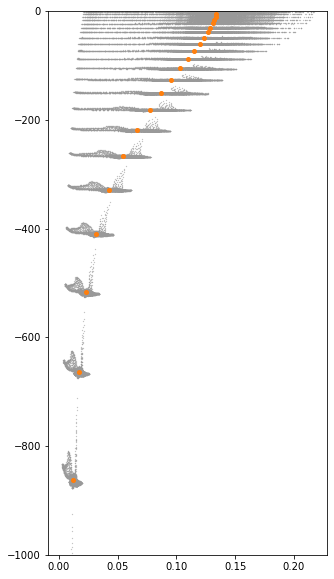

In [23]:
fig,ax=plt.subplots(figsize=(5,10))
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(truth.eke_mean.isel(eta_rho=ee,xi_rho=xx),truth.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(truth.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,truth.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')

ax.set_ylim(-1000,0)

(-1000.0, 0.0)

<Figure size 432x288 with 0 Axes>

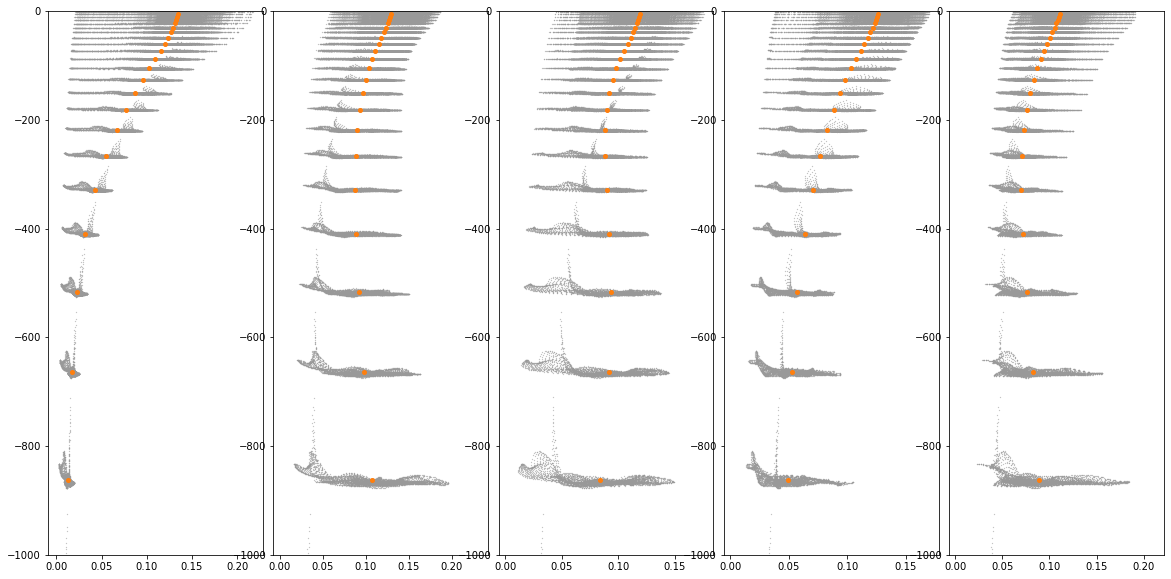

In [24]:


gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,10])
ax = None


ax = fig.add_subplot(gs[0,0])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(truth.eke_mean.isel(eta_rho=ee,xi_rho=xx),truth.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(truth.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,truth.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-1000,0)

ax = fig.add_subplot(gs[0,1])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-1000,0)

ax = fig.add_subplot(gs[0,2])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT_N.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT_N.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT_N.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT_N.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-1000,0)

ax = fig.add_subplot(gs[0,3])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT_S.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT_S.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT_S.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT_S.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-1000,0)

ax = fig.add_subplot(gs[0,4])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-1000,0)

(-4500.0, 0.0)

<Figure size 432x288 with 0 Axes>

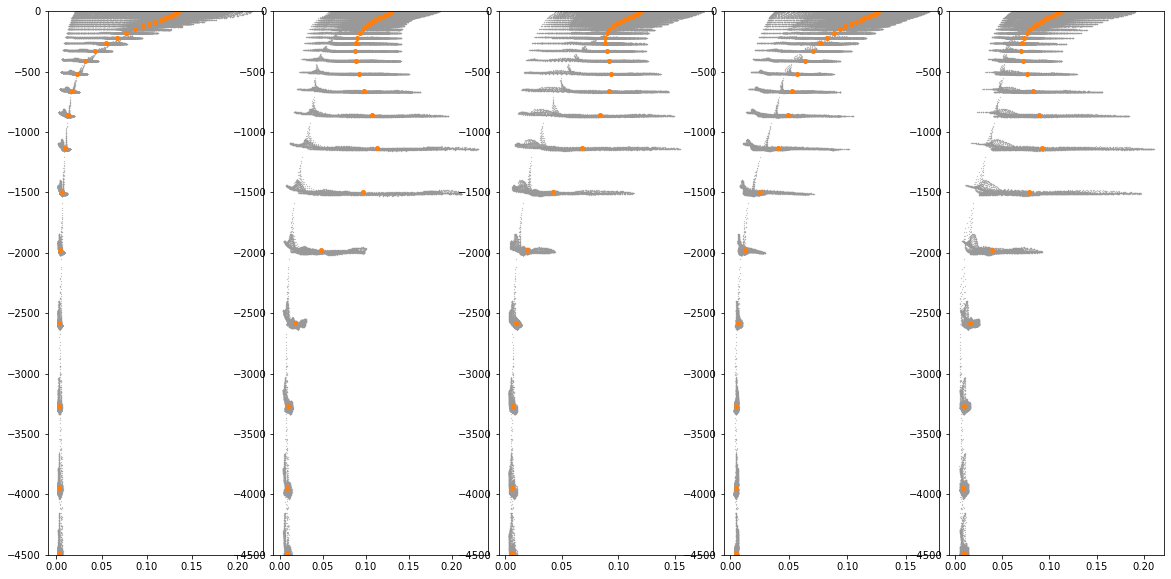

In [25]:


gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,10])
ax = None


ax = fig.add_subplot(gs[0,0])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(truth.eke_mean.isel(eta_rho=ee,xi_rho=xx),truth.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(truth.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,truth.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-4500,0)

ax = fig.add_subplot(gs[0,1])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-4500,0)

ax = fig.add_subplot(gs[0,2])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT_N.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT_N.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT_N.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT_N.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-4500,0)

ax = fig.add_subplot(gs[0,3])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT_S.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT_S.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT_S.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT_S.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-4500,0)

ax = fig.add_subplot(gs[0,4])
for ee in np.arange(etas[0],etas[1]):
    for xx in np.arange(xis[0],xis[1]):
        ax.plot(SSHSST_XBT.eke_mean.isel(eta_rho=ee,xi_rho=xx),SSHSST_XBT.z_rho0.isel(eta_rho=ee,xi_rho=xx),'.',markersize=0.5,color='0.6')
for ss in np.arange(0,29):
        ax.plot(SSHSST_XBT.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,SSHSST_XBT.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho']).values,'o',markersize=4,color='C1')
ax.set_ylim(-4500,0)

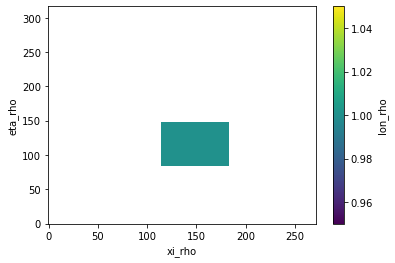

In [26]:
# Brief interlude to test the various area averaging functions
weights = truth_bu.dA
weights.name = "weights"
# test = truth.temp.isel(s_rho=-1).weighted(weights).mean(("eta_rho","xi_rho"))

# make a mask
etaLims = etas #exclusive mask
xiLims = xis

mask = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho']))*(truth.lon_rho*0+1)).where((truth.eta_rho>etaLims[0]) & (truth.eta_rho<etaLims[1]) & (truth.xi_rho>xiLims[0]) & (truth.xi_rho<xiLims[1]))
mask.plot()
plt.show()
# test = truth.temp.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))

In [27]:
test1=np.zeros(30)
test2=np.zeros(30)
test3=np.zeros(30)
test4=np.zeros(30)
test5=np.zeros(30)
test6=np.zeros(30)
test7=np.zeros(30)
test8=np.zeros(30)
test9=np.zeros(30)
test10=np.zeros(30)
test11=np.zeros(30)
test12=np.zeros(30)
test13=np.zeros(30)
test14=np.zeros(30)
test15=np.zeros(30)

for ss in np.arange(0,29):
    
    test1[ss]=truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    truth["eke_xymean"] = (('s_rho'),test1)
    test2[ss] = truth.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    truth["z_rho_xymean"]=(('s_rho'),test2)
    test3[ss]=SSHSST.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST["eke_xymean"] = (('s_rho'),test3)
    test4[ss] = SSHSST.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST["z_rho_xymean"]=(('s_rho'),test4)    
    test5[ss]=SSHSST_XBT_N.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT_N["eke_xymean"] = (('s_rho'),test5)
    test6[ss] = SSHSST_XBT_N.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT_N["z_rho_xymean"]=(('s_rho'),test6)        
    test7[ss]=SSHSST_XBT_S.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT_S["eke_xymean"] = (('s_rho'),test7)
    test8[ss] = SSHSST_XBT_S.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT_S["z_rho_xymean"]=(('s_rho'),test8)     
    test9[ss]=SSHSST_XBT.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT["eke_xymean"] = (('s_rho'),test9)
    test10[ss] = SSHSST_XBT.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    SSHSST_XBT["z_rho_xymean"]=(('s_rho'),test10)     

        
    test11[ss]=truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    truth["eke_xystd"] = (('s_rho'),test11)
    test12[ss]=SSHSST.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    SSHSST["eke_xystd"] = (('s_rho'),test12)
    test13[ss]=SSHSST_XBT_N.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    SSHSST_XBT_N["eke_xystd"] = (('s_rho'),test13)
    test14[ss]=SSHSST_XBT_S.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    SSHSST_XBT_S["eke_xystd"] = (('s_rho'),test14)
    test15[ss]=SSHSST_XBT.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    SSHSST_XBT["eke_xystd"] = (('s_rho'),test15)
    

In [28]:
truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))

<xarray.DataArray 'eke_mean' ()>
array(0.03009772)
Coordinates:
    s_rho    float64 -0.0156

In [29]:
truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))

<xarray.DataArray 'eke_mean' ()>
array(0.13321606)
Coordinates:
    s_rho    float64 -0.0156

In [30]:
truth.eke_xystd

<xarray.DataArray 'eke_xystd' (s_rho: 30)>
array([0.00099319, 0.00099564, 0.00098908, 0.00095265, 0.00104312,
       0.00136486, 0.00187467, 0.00245163, 0.00308167, 0.00403983,
       0.00557195, 0.00782323, 0.01067399, 0.01374561, 0.0166213 ,
       0.01914055, 0.0213038 , 0.02318812, 0.02488563, 0.02635856,
       0.02752841, 0.02833294, 0.02885474, 0.02919905, 0.02944872,
       0.02966449, 0.02987452, 0.03002009, 0.03009772, 0.        ])
Coordinates:
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799

In [31]:
# old averaging method - not exact

# test1=np.zeros(30)
# test2=np.zeros(30)
# test3=np.zeros(30)
# test4=np.zeros(30)
# test5=np.zeros(30)
# test6=np.zeros(30)
# test7=np.zeros(30)
# test8=np.zeros(30)
# test9=np.zeros(30)
# test10=np.zeros(30)

# for ss in np.arange(0,29):
    
#     test1[ss]=truth.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     truth["eke_xymean"] = (('s_rho'),test1)
#     test2[ss] = truth.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     truth["z_rho_xymean"]=(('s_rho'),test2)
#     test3[ss]=SSHSST.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST["eke_xymean"] = (('s_rho'),test3)
#     test4[ss] = SSHSST.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST["z_rho_xymean"]=(('s_rho'),test4)    
#     test5[ss]=SSHSST_XBT_N.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT_N["eke_xymean"] = (('s_rho'),test5)
#     test6[ss] = SSHSST_XBT_N.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT_N["z_rho_xymean"]=(('s_rho'),test6)        
#     test7[ss]=SSHSST_XBT_S.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT_S["eke_xymean"] = (('s_rho'),test7)
#     test8[ss] = SSHSST_XBT_S.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT_S["z_rho_xymean"]=(('s_rho'),test8)     
#     test9[ss]=SSHSST_XBT.eke_mean.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT["eke_xymean"] = (('s_rho'),test9)
#     test10[ss] = SSHSST_XBT.z_rho0.isel(eta_rho=slice(etas[0],etas[1]),xi_rho=slice(xis[0],xis[1]),s_rho=ss).mean(dim=['eta_rho','xi_rho'])
#     SSHSST_XBT["z_rho_xymean"]=(('s_rho'),test10)     
    

<Figure size 432x288 with 0 Axes>

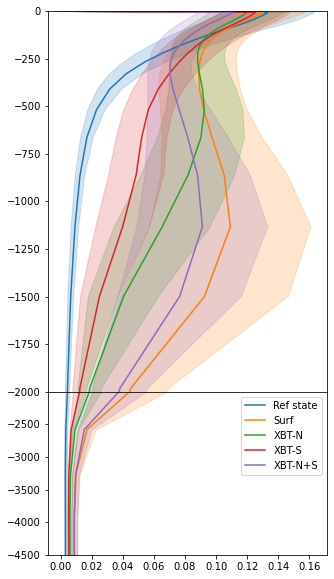

In [32]:


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,10])
ax = None

def plot_std(var,yvar,label):
    C_std = var.std('PROFILE')
    C.plot(y='DEPTH',label=label)
    plt.fill_betweenx(yvar, C-C_std,C+C_std, alpha=0.2)
    plt.ylim(max_depth,min(yvar))

ax = fig.add_subplot(gs[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.fill_betweenx(SSHSST.z_rho_xymean,SSHSST.eke_xymean-SSHSST.eke_xystd,SSHSST.eke_xymean+SSHSST.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.fill_betweenx(SSHSST_XBT_N.z_rho_xymean,SSHSST_XBT_N.eke_xymean-SSHSST_XBT_N.eke_xystd,SSHSST_XBT_N.eke_xymean+SSHSST_XBT_N.eke_xystd, alpha=0.2, edgecolor='C2')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.fill_betweenx(SSHSST_XBT_S.z_rho_xymean,SSHSST_XBT_S.eke_xymean-SSHSST_XBT_S.eke_xystd,SSHSST_XBT_S.eke_xymean+SSHSST_XBT_S.eke_xystd, alpha=0.2, edgecolor='C3')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')
ax.fill_betweenx(SSHSST_XBT.z_rho_xymean,SSHSST_XBT.eke_xymean-SSHSST_XBT.eke_xystd,SSHSST_XBT.eke_xymean+SSHSST_XBT.eke_xystd, alpha=0.2, edgecolor='C4')

ax.set_ylim(-2000,0)
ax.set_xticklabels([])

ax = fig.add_subplot(gs[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.fill_betweenx(SSHSST.z_rho_xymean,SSHSST.eke_xymean-SSHSST.eke_xystd,SSHSST.eke_xymean+SSHSST.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.fill_betweenx(SSHSST_XBT_N.z_rho_xymean,SSHSST_XBT_N.eke_xymean-SSHSST_XBT_N.eke_xystd,SSHSST_XBT_N.eke_xymean+SSHSST_XBT_N.eke_xystd, alpha=0.2, edgecolor='C2')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.fill_betweenx(SSHSST_XBT_S.z_rho_xymean,SSHSST_XBT_S.eke_xymean-SSHSST_XBT_S.eke_xystd,SSHSST_XBT_S.eke_xymean+SSHSST_XBT_S.eke_xystd, alpha=0.2, edgecolor='C3')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')
ax.fill_betweenx(SSHSST_XBT.z_rho_xymean,SSHSST_XBT.eke_xymean-SSHSST_XBT.eke_xystd,SSHSST_XBT.eke_xymean+SSHSST_XBT.eke_xystd, alpha=0.2, edgecolor='C4')


ax.set_ylim(-4500,-2001)



ax.legend()



In [33]:
# fig,ax=plt.subplots(figsize=(5,10))
# ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
# ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
# ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
# ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')

# ax.set_ylim(-5000,0)
# ax.legend()



In [34]:
def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

# Now make depth averages

In [ ]:
truth["eke0to250"] =grid.average(truth.eke.where(truth.z_rho0>-250),'Z')
SSHSST["eke0to250"] =grid.average(SSHSST.eke.where(SSHSST.z_rho0>-250),'Z')
SSHSST_XBT_N["eke0to250"] =grid.average(SSHSST_XBT_N.eke.where(SSHSST_XBT_N.z_rho0>-250),'Z')
SSHSST_XBT_S["eke0to250"] =grid.average(SSHSST_XBT_S.eke.where(SSHSST_XBT_S.z_rho0>-250),'Z')
SSHSST_XBT["eke0to250"] =grid.average(SSHSST_XBT.eke.where(SSHSST_XBT.z_rho0>-250),'Z')


truth["eke250to2500"] =grid.average(truth.eke.where((truth.z_rho0<-250) & (truth.z_rho0>-2500)),'Z')
SSHSST["eke250to2500"] =grid.average(SSHSST.eke.where((SSHSST.z_rho0<-250) & (SSHSST.z_rho0>-2500)),'Z')
SSHSST_XBT_N["eke250to2500"] =grid.average(SSHSST_XBT_N.eke.where((SSHSST_XBT_N.z_rho0<-250) & (SSHSST_XBT_N.z_rho0>-2500)),'Z')
SSHSST_XBT_S["eke250to2500"] =grid.average(SSHSST_XBT_S.eke.where((SSHSST_XBT_S.z_rho0<-250) & (SSHSST_XBT_S.z_rho0>-2500)),'Z')
SSHSST_XBT["eke250to2500"] =grid.average(SSHSST_XBT.eke.where((SSHSST_XBT.z_rho0<-250) & (SSHSST_XBT.z_rho0>-2500)),'Z')



truth["eke250to2000"] =grid.average(truth.eke.where((truth.z_rho0<-250) & (truth.z_rho0>-2000)),'Z')
SSHSST["eke250to2000"] =grid.average(SSHSST.eke.where((SSHSST.z_rho0<-250) & (SSHSST.z_rho0>-2000)),'Z')
SSHSST_XBT_N["eke250to2000"] =grid.average(SSHSST_XBT_N.eke.where((SSHSST_XBT_N.z_rho0<-250) & (SSHSST_XBT_N.z_rho0>-2000)),'Z')
SSHSST_XBT_S["eke250to2000"] =grid.average(SSHSST_XBT_S.eke.where((SSHSST_XBT_S.z_rho0<-250) & (SSHSST_XBT_S.z_rho0>-2000)),'Z')
SSHSST_XBT["eke250to2000"] =grid.average(SSHSST_XBT.eke.where((SSHSST_XBT.z_rho0<-250) & (SSHSST_XBT.z_rho0>-2000)),'Z')


In [ ]:
 # mean value of top250m in EKE box
box_EKEvar = {'xi_rho': slice(xis[0],xis[1]),'eta_rho': slice(etas[0],etas[1])}
(truth.eke0to250.mean(dim='ocean_time').isel(box_EKEvar)*truth.dA.isel(box_EKEvar)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth.dA.isel(box_EKEvar)).sum(dim=['eta_rho','xi_rho'],skipna=True)

In [ ]:
# calc RMS values

RMS_SSHSST_0to250 = (((truth.eke0to250 - SSHSST.eke0to250)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_N_0to250 = (((truth.eke0to250 - SSHSST_XBT_N.eke0to250)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_S_0to250 = (((truth.eke0to250 - SSHSST_XBT_S.eke0to250)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_0to250 = (((truth.eke0to250 - SSHSST_XBT.eke0to250)**2).mean(dim='ocean_time'))**.5


RMS_SSHSST_250to2500 = (((truth.eke250to2500 - SSHSST.eke250to2500)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_N_250to2500 = (((truth.eke250to2500 - SSHSST_XBT_N.eke250to2500)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_S_250to2500 = (((truth.eke250to2500 - SSHSST_XBT_S.eke250to2500)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_250to2500 = (((truth.eke250to2500 - SSHSST_XBT.eke250to2500)**2).mean(dim='ocean_time'))**.5


RMS_SSHSST_250to2000 = (((truth.eke250to2000 - SSHSST.eke250to2000)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_N_250to2000 = (((truth.eke250to2000 - SSHSST_XBT_N.eke250to2000)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_S_250to2000 = (((truth.eke250to2000 - SSHSST_XBT_S.eke250to2000)**2).mean(dim='ocean_time'))**.5
RMS_SSHSST_XBT_250to2000 = (((truth.eke250to2000 - SSHSST_XBT.eke250to2000)**2).mean(dim='ocean_time'))**.5

In [ ]:


plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8.4])
ax = None
gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.825,.175],wspace=0.1)

gs00 = gs[0].subgridspec(2, 5,wspace=0.05, hspace=0.05)
gs01 = gs[1].subgridspec(2, 1,hspace=0.0)

ax = fig.add_subplot(gs00[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke0to250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.2)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.02, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (0-250m) & RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_0to250.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_XBT_N_0to250.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_XBT_S_0to250.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=RMS_SSHSST_XBT_0to250.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 



ax = fig.add_subplot(gs00[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke250to2500.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.03)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.02, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (250-2500m) & RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_250to2500.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_XBT_N_250to2500.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
RMS_SSHSST_XBT_S_250to2500.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=RMS_SSHSST_XBT_250to2500.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=0,vmax=0.5)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.02, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="10%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.1,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title(' EKE \n ($m^2/s^2$)')

# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.96, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)





ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')

ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.3,0)

ax = fig.add_subplot(gs01[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')

ax.set_ylim(-4500,-2001)
ax.set_xlim(0,0.15)
ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
ax.yaxis.tick_right()
ax.legend()


In [ ]:


plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8.4])
ax = None
gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.825,.175],wspace=0.1)

gs00 = gs[0].subgridspec(2, 5,wspace=0.05, hspace=0.05)
gs01 = gs[1].subgridspec(2, 1,hspace=0.0)

ax = fig.add_subplot(gs00[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke0to250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.2)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (0-250m) & diff',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_N.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_S.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=(SSHSST_XBT.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 



ax = fig.add_subplot(gs00[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke250to2500.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.03)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (250-2500m) & diff',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST.eke250to2500-truth.eke250to2500).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_N.eke250to2500-truth.eke250to2500).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_S.eke250to2500-truth.eke250to2500).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=(SSHSST_XBT.eke250to2500-truth.eke250to2500).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="10%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.1,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title(' EKE \n ($m^2/s^2$)')

# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.96, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)





ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')

ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.3,0)

ax = fig.add_subplot(gs01[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')

ax.set_ylim(-4500,-2001)
ax.set_xlim(0,0.15)
ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
ax.yaxis.tick_right()
ax.legend()


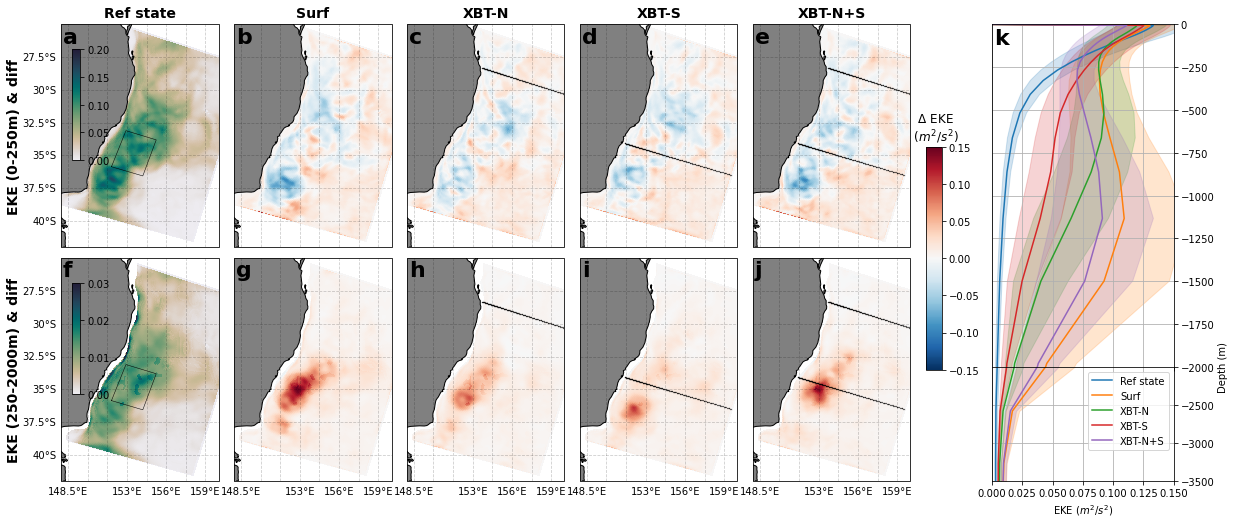

In [40]:


plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8.4])
ax = None
gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.825,.175],wspace=0.15)

gs00 = gs[0].subgridspec(2, 5,wspace=0.05, hspace=0.05)
gs01 = gs[1].subgridspec(2, 1,hspace=0.0,height_ratios=[.75,.25])

ax = fig.add_subplot(gs00[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke0to250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.2)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (0-250m) & diff',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_N.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_S.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=(SSHSST_XBT.eke0to250-truth.eke0to250).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthMLD,colors='.3',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.3', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthMLD,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 



ax = fig.add_subplot(gs00[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.eke250to2000.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.rain',vmin=0,vmax=0.03)
# co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.3, .5, 'EKE (250-2000m) & diff',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
ax.plot(boxLo,boxLa,color='k',linewidth=0.5)
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs00[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST.eke250to2000-truth.eke250to2000).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_N.eke250to2000-truth.eke250to2000).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
(SSHSST_XBT_S.eke250to2000-truth.eke250to2000).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs00[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=(SSHSST_XBT.eke250to2000-truth.eke250to2000).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-.15,vmax=0.15)
# co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthTC,colors='.9',levels=np.arange(-160,20,20),linestyles='solid')
# ax.clabel(co, colors='.9', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

cax = inset_axes(ax,
                width="10%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.1,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title(' $\Delta$ EKE \n ($m^2/s^2$)')

# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.96, fontsize=14, fontweight='bold')
# fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)






ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.fill_betweenx(SSHSST.z_rho_xymean,SSHSST.eke_xymean-SSHSST.eke_xystd,SSHSST.eke_xymean+SSHSST.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.fill_betweenx(SSHSST_XBT_N.z_rho_xymean,SSHSST_XBT_N.eke_xymean-SSHSST_XBT_N.eke_xystd,SSHSST_XBT_N.eke_xymean+SSHSST_XBT_N.eke_xystd, alpha=0.2, edgecolor='C2')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.fill_betweenx(SSHSST_XBT_S.z_rho_xymean,SSHSST_XBT_S.eke_xymean-SSHSST_XBT_S.eke_xystd,SSHSST_XBT_S.eke_xymean+SSHSST_XBT_S.eke_xystd, alpha=0.2, edgecolor='C3')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')
ax.fill_betweenx(SSHSST_XBT.z_rho_xymean,SSHSST_XBT.eke_xymean-SSHSST_XBT.eke_xystd,SSHSST_XBT.eke_xymean+SSHSST_XBT.eke_xystd, alpha=0.2, edgecolor='C4')


ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.3,0)

ax = fig.add_subplot(gs01[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(SSHSST.eke_xymean,SSHSST.z_rho_xymean,label='Surf')
ax.fill_betweenx(SSHSST.z_rho_xymean,SSHSST.eke_xymean-SSHSST.eke_xystd,SSHSST.eke_xymean+SSHSST.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(SSHSST_XBT_N.eke_xymean,SSHSST_XBT_N.z_rho_xymean,label='XBT-N')
ax.fill_betweenx(SSHSST_XBT_N.z_rho_xymean,SSHSST_XBT_N.eke_xymean-SSHSST_XBT_N.eke_xystd,SSHSST_XBT_N.eke_xymean+SSHSST_XBT_N.eke_xystd, alpha=0.2, edgecolor='C2')
ax.plot(SSHSST_XBT_S.eke_xymean,SSHSST_XBT_S.z_rho_xymean,label='XBT-S')
ax.fill_betweenx(SSHSST_XBT_S.z_rho_xymean,SSHSST_XBT_S.eke_xymean-SSHSST_XBT_S.eke_xystd,SSHSST_XBT_S.eke_xymean+SSHSST_XBT_S.eke_xystd, alpha=0.2, edgecolor='C3')
ax.plot(SSHSST_XBT.eke_xymean,SSHSST_XBT.z_rho_xymean,label='XBT-N+S')
ax.fill_betweenx(SSHSST_XBT.z_rho_xymean,SSHSST_XBT.eke_xymean-SSHSST_XBT.eke_xystd,SSHSST_XBT.eke_xymean+SSHSST_XBT.eke_xystd, alpha=0.2, edgecolor='C4')


ax.set_ylim(-3500,-2001)
ax.set_xlim(0,0.15)
ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
ax.yaxis.tick_right()
ax.legend()


In [41]:
etas

array([ 84, 149])

In [42]:
xis

array([114, 184])

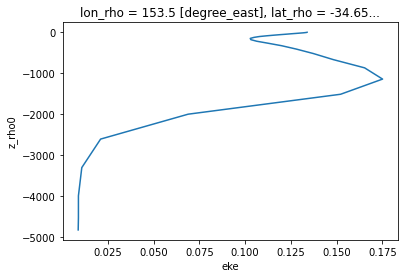

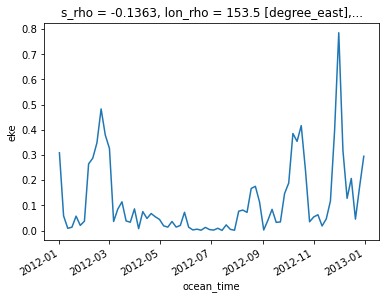

In [43]:
SSHSST.eke.isel(eta_rho=120,xi_rho=150).mean(dim='ocean_time').plot(y='z_rho0')
plt.show()
SSHSST.eke.isel(s_rho=21,eta_rho=120,xi_rho=150).plot()

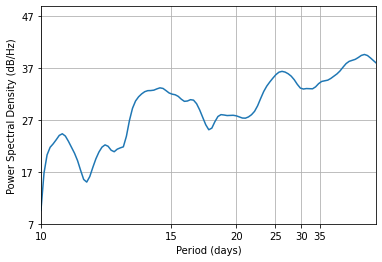

In [44]:
fig,ax=plt.subplots(1)
ax.psd(SSHSST.eke.isel(s_rho=21,eta_rho=120,xi_rho=150), Fs=1/432000,detrend='linear')
ax.set_xticks([1/86400,1/(5*86400),1/(10*86400),1/(15*86400),1/(20*86400),1/(25*86400),1/(30*86400),1/(35*86400)])
ax.set_xticklabels([1,5,10,15,20,25,30,35])
ax.invert_xaxis()
ax.set_xlim([1/(10*86400),1/(70*86400)])
ax.set_xlabel('Period (days)')
plt.show()

In [45]:
SSHSST.eke.ocean_time[-1]-SSHSST.eke.ocean_time[0]

<xarray.DataArray 'ocean_time' ()>
array(31536000000000000, dtype='timedelta64[ns]')

In [46]:
len(SSHSST.eke.ocean_time)

74

In [47]:
31536000000000000e-9/86400

365.0